# 1. Imports

In [1]:
import torch
import torchinfo
import torchinfo
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os 
from sklearn.metrics import f1_score, confusion_matrix
from typing import Optional, Union

In [4]:
print(torchvision.__version__)

0.14.0+cpu


#2. 

In [2]:
image_path = "./Covid19-dataset"

In [1]:
# Get pretrained model weights and its transformations to apply them to the image data in order to train to the model later
weights = torchvision.models.resnet18.DEFAULT
transforms = weights.transforms
print(transforms)

NameError: name 'torchvision' is not defined

In [4]:
# get model infos
model = torchvision.models.vgg16(weights) 
print(model.classifier)

C:\Users\bierl\anaconda3\envs\lemon_quality_cv\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [5]:
# Add custom transforms on top of needed transforms for the pretrained model
base_transforms = [
    tt.Resize((256,256), interpolation = tt.InterpolationMode.BICUBIC),
]

transforms_custom = tt.Compose([
    *base_transforms,
    tt.RandomCrop(224),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(30),
    tt.RandomVerticalFlip(),
    tt.ToTensor()
])

test_transforms = tt.Compose([
    *base_transforms,
    tt.ToTensor()
])

In [6]:
# Load images into ImageFolder
train_images = ImageFolder(image_path+"/train", transform=transforms_custom)
test_images = ImageFolder(image_path + "/test", transform=test_transforms)

In [7]:
# Create dataloader
train_loader = DataLoader(train_images, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_images, batch_size=16, shuffle=True, num_workers=2)

In [8]:
# create label distribution of training data for further investigation
label_dist = {}
for img_class in os.listdir(image_path + "/train"):
  counter = 0 
  for img in os.listdir(image_path + "/train" + "/" +  img_class):
    counter += 1 
  label_dist[img_class] = counter

inverse_class_weights = [1/(count/sum(label_dist.values())) for count in label_dist.values() ]

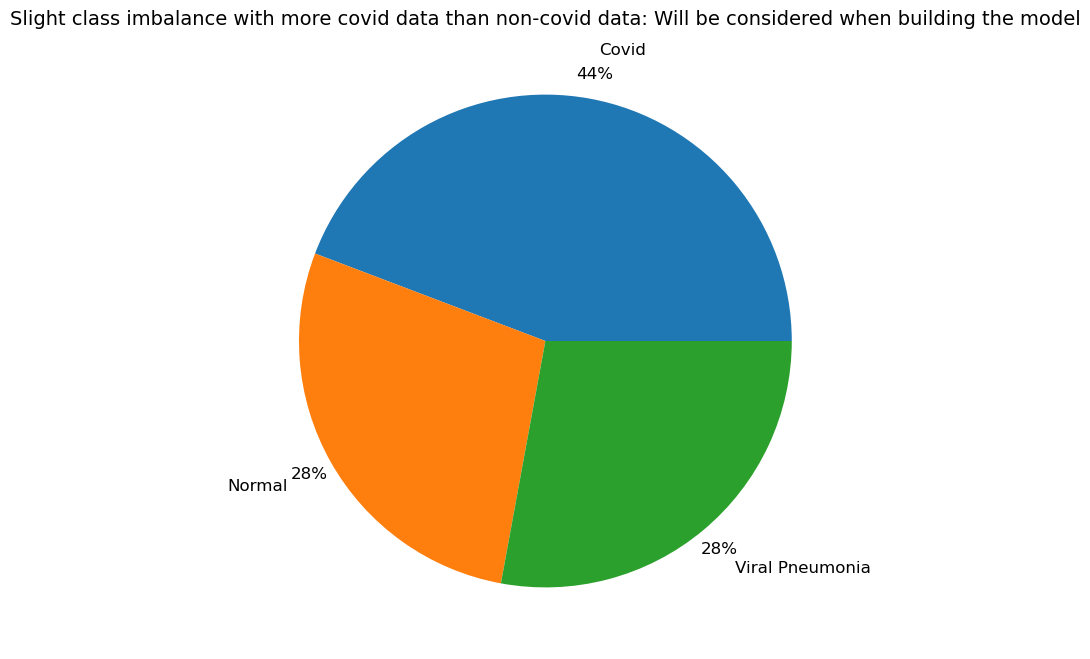

In [9]:
# plot the label distribution
fig,ax = plt.subplots(figsize=(8,8))
ax.pie(label_dist.values(), labels=label_dist.keys(), autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, textprops={"fontsize":12})
plt.title("Slight class imbalance with more covid data than non-covid data: Will be considered when building the model", fontsize=14)
plt.show()

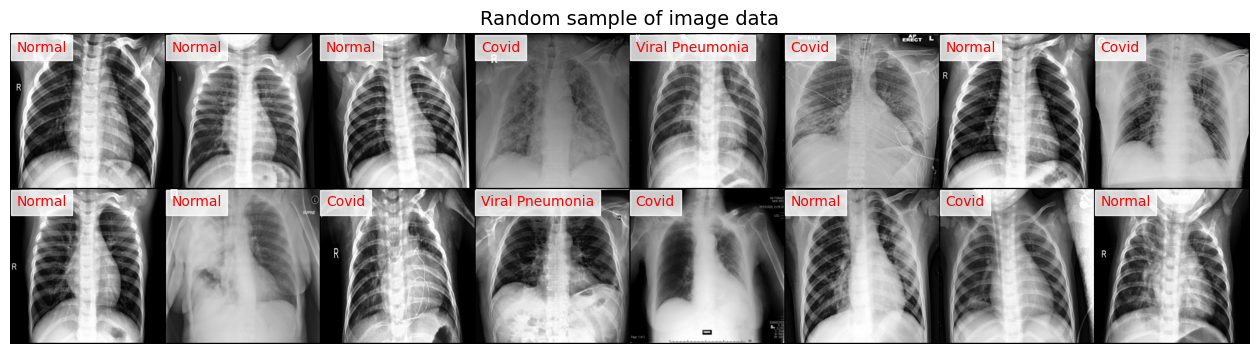

In [10]:
# Plot grid of test images, which are not augmented
for batch in test_loader:
  images,labels = batch
  grid = make_grid(images)
  grid = grid.permute(1,2,0) # permute dimensions to make it plotable for matplotlib
  break

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(grid)

ncol = 8
nrow = 2

# Add labels to each grid member with a white bounding box
for col in range(ncol):
  for row in range(nrow):
    label = test_images.classes[labels[col + row]]
    t = plt.text(x=(col) * 258 + 10, y = (row) * 258 + 30, s=label , color="red", fontsize=10)
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax.axis('off')
plt.title("Random sample of image data", fontsize=14)
plt.show()

In [11]:
# Build device data loader to make gpu training possible

def get_default_device():
  """
  Pick GPU if it is available otherwise CPU
  """
  if torch.cuda.is_available:
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  else:
    return data.to(device, non_blocking=True)
  
class DeviceDataLoader:
  """
  Wrap a dataloader to move data to device
  """

  def __init__(self, dl ,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """
    Yield a batch of data after moving it to device
    :return: To new device transformed dataloader
    """
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    """
    Number of batches
    """
    return len(self.dl)

In [12]:
# Build the model

class Model(nn.Module):
  def __init__(self, train_backbone_params=True):
    super().__init__()
    self.train_backbone_params = train_backbone_params

    self.model = self.init_model()
  
  
  def forward(self, xb):
    """
    Simple forward step

    :param xb: input data
    :type xb: torch.tensor
    :return: output of the model
    :rtype: torch.tensor
    """
    out = self.model(xb)
    return out
  
  def init_model(self):
    """
    Setup backbone model
    """
    weights = torchvision.models.VGG16_Weights.DEFAULT
    model = torchvision.models.vgg16(weights) 

    if self.train_backbone_params:
      for param in model.parameters():
        param.requires_grad = True
    else:
      for param in model.parameters():
        param.requires_grad = False
    
    classifier = nn.Sequential(
         nn.Linear(in_features=25088, out_features=3)
    )

    model.classifier = classifier
    return  model
  
  def training_step(self, batch):
    """
    Training step which computes the loss and accuracy of a train batch
    :param batch: batch of pytorch dataloader
    :type batch: torch.utils.data.DataLoader
    :return: loss, accuracy and f1_score of batch
    :rtype: tuple[torch.tensor,...]
    """
    images, labels =  batch
    out = self(images) 
    train_loss = F.cross_entropy(out,labels, weight=inverse_class_weights)
    train_acc = accuracy(out,labels)
    train_f1 = f1(out, labels)

    return train_loss, train_acc, train_f1
  
  def validation_step(self,batch):
    images, labels =  batch
    out = self(images)
    val_loss = F.cross_entropy(out,labels) # without class weights!
    val_accuracy = accuracy(out,labels)
    val_f1 = f1(out, labels)

    return {"val_loss": val_loss, "val_acc": val_accuracy, "val_f1": val_f1}

  def validation_epoch_end(self, outputs):
    """
    Returns the epoch losses after computing the mean loss and accuracy of the test batches

    :param outputs: List of test step outputs
    :type outputs: list
    :return: epoch loss and epoch accuracy
    :rtype: dict
    """
    batch_losses = [x["val_loss"] for x in outputs]
    batch_acc = [x["val_acc"] for x in outputs]
    batch_f1 = [x["val_f1"] for x in outputs]

    epoch_loss = torch.stack(batch_losses).mean().item()
    epoch_acc = torch.stack(batch_acc).mean().item()
    epoch_f1 = np.mean(batch_f1)
    return {"val_loss": epoch_loss, "val_acc": epoch_acc, "val_f1": epoch_f1}

  def evaluate(self, dl):
    with torch.no_grad():
      self.eval()
      outputs = [self.validation_step(batch) for batch in dl]
      return self.validation_epoch_end(outputs)
  
  def epoch_end_val(self, epoch, results):
    """
    Prints test epoch summary after every epoch

    :param epoch: epoch number
    :type epoch: int
    :param results: results from the evaluate method
    :type results: dictionary
    :return: None
    """

    print(f"Epoch:[{epoch}]: validation loss: {results['val_loss']}, validation accuracy: {results['val_acc']},validation f1_score: {results['val_f1']}")
    
    

In [13]:
# define helper functions and classes
def accuracy(prediction, labels):
  """
  Computes the accuracy of a prediction

  :param output: Prediction outputs
  :type output: torch.tensor
  :param labels: True labels for the output
  :type labels: torch.tensor
  :return: accuracy of the prediction
  :rtype: torch.tensor
  """

  _, preds = torch.max(prediction, dim=1)
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


def f1(prediction, labels):
  """
  Computes the f1_score of a prediction

  :param output: Prediction outputs
  :type output: torch.tensor
  :param labels: True labels for the output
  :type labels: torch.tensor
  :return: f1_score of the prediction
  :rtype: torch.tensor
  """
  output = prediction.cpu() # transfer them to cpu to make coversion to numpy arrays possible 
  labels = labels.cpu()
  _, preds = torch.max(output, dim=1)
  return f1_score(labels, preds, average="macro")


# Early Stopper class for training 
class EarlyStopper:
  def __init__(self,min_delta=0, patience_steps=5):
    self.min_delta = min_delta
    self.patience_steps = patience_steps
    self.counter = 0
    self.min_validation_loss = np.inf
  
  def early_stop(self, new_val_loss):
    """
    Returns True if criterion for early stop is met
    :param new_val_loss: validation loss of epoch
    :param float:
    :return: True if early stop should be done, False otherwise
    :rtype: bool
    """
    if self.min_validation_loss > new_val_loss:
      self.min_validation_loss = new_val_loss
      self.counter = 0
    elif self.min_validation_loss + self.min_delta <= new_val_loss:
        if self.counter >= self.patience_steps:
          return True
        else:
          self.counter += 1
    else:
      return False

In [14]:
# training function
def fit(model: Union[Model, nn.Module], epochs: int, train_loader: torch.utils.data.dataloader.DataLoader, val_loader: torch.utils.data.dataloader.DataLoader,
        optimizer: torch.optim, learning_rate: float, early_stopping: bool, lr_scheduler: torch.optim.lr_scheduler, **kwargs):
  """
  Fits the model with defined optimizer, learning rate scheduler, early stopper  and laerning rate

  :param model: PyTorch model which should be trained
  :param epochs: Number of epochs
  :param train_loader: DataLoader for training data
  :param val_loader: DataLoader for validation data
  :param optimizer: PyTorch optimizer to optimize the loss
  :param learning_rate: Learning rate for the optimizer
  :param early_stopping: True if early stopping should be checked
  :param lr_scheduler: PyTorch learning rate scheduler to adjust the learning rate
  :param **kwargs: additional keyword arguments for the learning rate scheduler
  :return: history of training
  :rtype: list
  """
  
  optimizer = optimizer(model.parameters(), lr=learning_rate)
  if lr_scheduler:
    lrs = lr_scheduler(optimizer, **kwargs)
  
  if early_stopping:
    early_stopper = EarlyStopper()

  history = []

  for epoch in range(epochs):
    train_losses = []
    train_acc = []
    train_f1 = []
    for num, batch in enumerate(train_loader):
      print(f"New batch [{num}]")
      loss, acc, f1 = model.training_step(batch)
      train_losses.append(loss)
      train_acc.append(acc)
      train_f1.append(f1)
    
      optimizer.step()
  
    result = model.evaluate(val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_f1"] = np.mean(train_f1)

    history.append(result)
  
    if lr_scheduler:
      lrs.step(metrics=result["val_loss"])

    if early_stopping:
      if early_stopper.early_stop(result["val_loss"]):
        break

    model.epoch_end_val(epoch,result)
  
  return history

In [15]:
# Send models and data to gpu if possible
device = get_default_device()
device = torch.device("cpu")
model = Model()
model = to_device(model, device)

train_loader_to_device = DeviceDataLoader(train_loader, device)
test_loader_to_device = DeviceDataLoader(test_loader, device)

inverse_class_weights = to_device(torch.tensor(inverse_class_weights), device)
#print summary
print(torchinfo.summary(model, input_size=(32,3,256,256)))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 3]                   --
├─VGG: 1-1                               [32, 3]                   --
│    └─Sequential: 2-1                   [32, 512, 8, 8]           --
│    │    └─Conv2d: 3-1                  [32, 64, 256, 256]        1,792
│    │    └─ReLU: 3-2                    [32, 64, 256, 256]        --
│    │    └─Conv2d: 3-3                  [32, 64, 256, 256]        36,928
│    │    └─ReLU: 3-4                    [32, 64, 256, 256]        --
│    │    └─MaxPool2d: 3-5               [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-6                  [32, 128, 128, 128]       73,856
│    │    └─ReLU: 3-7                    [32, 128, 128, 128]       --
│    │    └─Conv2d: 3-8                  [32, 128, 128, 128]       147,584
│    │    └─ReLU: 3-9                    [32, 128, 128, 128]       --
│    │    └─MaxPool2d: 3-10              [32, 128, 64, 64]         --

In [17]:
# fit the model using the predefined fit function
history = fit(model, 10, train_loader_to_device, test_loader_to_device, torch.optim.Adam, 0.0001, False,
              torch.optim.lr_scheduler.ReduceLROnPlateau, patience=2, factor=0.1 )

New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[0]: validation loss: 1.1215227842330933, validation accuracy: 0.26249998807907104,validation f1_score: 0.19493561993561995
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[1]: validation loss: 1.1220871210098267, validation accuracy: 0.17499999701976776,validation f1_score: 0.14376068376068377
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[2]: validation loss: 1.1803324222564697, validation accuracy: 0.17499999701976776,validation f1_score: 0.13002849002849
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[3]: validation loss: 1.1367475986480713, validation accuracy: 0.17499999701976776,validation f1_score: 0.15125985125985125
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[4]: validation loss: 1.1307992935180664, validation accuracy: 0.17499999701976776,validation f1_score: 0.128003848003848
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[5]: validation loss: 1.1593087911605835, validation accuracy: 0.17499999701976776,validation f1_score: 0.1383485359955948
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[6]: validation loss: 1.118317723274231, validation accuracy: 0.26249998807907104,validation f1_score: 0.19394122217651627
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[7]: validation loss: 1.1286591291427612, validation accuracy: 0.17499999701976776,validation f1_score: 0.14480260480260482
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[8]: validation loss: 1.1321974992752075, validation accuracy: 0.17499999701976776,validation f1_score: 0.1355339105339105
New batch [0]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [1]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [2]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [3]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [4]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [5]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [6]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [7]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [8]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [9]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [10]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [11]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [12]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [13]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [14]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))


New batch [15]


C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bierl\AppData\Local\Temp\ipykernel_22508\1681313543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum((preds == labels)) / len(preds))
C:\Users\bier

Epoch:[9]: validation loss: 1.1292364597320557, validation accuracy: 0.17499999701976776,validation f1_score: 0.1436258186258186


In [18]:
history

[{'val_loss': 1.1215227842330933,
  'val_acc': 0.26249998807907104,
  'val_f1': 0.19493561993561995,
  'train_loss': 1.1250702142715454,
  'train_acc': 0.27627840638160706,
  'train_f1': 0.25112595737595733},
 {'val_loss': 1.1220871210098267,
  'val_acc': 0.17499999701976776,
  'val_f1': 0.14376068376068377,
  'train_loss': 1.122710943222046,
  'train_acc': 0.2908380627632141,
  'train_f1': 0.2506917646623529},
 {'val_loss': 1.1803324222564697,
  'val_acc': 0.17499999701976776,
  'val_f1': 0.13002849002849,
  'train_loss': 1.1255933046340942,
  'train_acc': 0.2848011255264282,
  'train_f1': 0.2640193412252236},
 {'val_loss': 1.1367475986480713,
  'val_acc': 0.17499999701976776,
  'val_f1': 0.15125985125985125,
  'train_loss': 1.1326721906661987,
  'train_acc': 0.2869318127632141,
  'train_f1': 0.2563245781995782},
 {'val_loss': 1.1307992935180664,
  'val_acc': 0.17499999701976776,
  'val_f1': 0.128003848003848,
  'train_loss': 1.103765606880188,
  'train_acc': 0.29829543828964233,
  't